In [1]:
from itertools import product

import numpy as np
from graspy.simulations import er_np, sbm
from graspy.plot import heatmap
from scipy.stats import ttest_ind
import pandas as pd

from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def generate_data(m = 1, n = [5, 15], p = 0.5, delta = 0, seed = None):
    np.random.seed(seed)
    p1 = [[p, p],
          [p, p]]
    p2 = [[p + delta, p],
          [p, p]]
    
    pop1 = []
    pop2 = []
    for _ in np.arange(m):
        pop1.append(sbm(n, p1))
        pop2.append(sbm(n, p2))
    
    pop1 = np.stack(pop1)
    pop2 = np.stack(pop2)
    return pop1, pop2

def compute_pvalue(pop1, pop2):
    _, pvals = ttest_ind(pop1, pop2, axis=0)
    np.nan_to_num(pvals, copy=False)
    
    return pvals

def compute_trustworthiness(different_n, pvals):
    idx = np.triu_indices(different_n, k=1)
    res = pvals[idx]
    
    fraction_correct = (res <=0.05).mean()
    all_correct = np.all(res <= 0.05)
    
    return fraction_correct, all_correct

In [3]:
def run_experiment(m, delta, seed, reps):
    fraction_corrects = []
    all_corrects = []
    
    for i in range(reps):
        pop1, pop2 = generate_data(m = m, n = n, p = p, delta=delta, seed = seed+i)
        pvals = compute_pvalue(pop1, pop2)
        fraction_correct, all_correct = compute_trustworthiness(block_1, pvals)
        
        fraction_corrects.append(fraction_correct)
        all_corrects.append(all_correct)
    
    # to_append = pd.Series([p, delta, m, fraction_correct, all_correct], index=cols)
    to_append = [p, delta, m, np.mean(fraction_corrects), np.mean(all_corrects)]

    return to_append

In [4]:
# for delta, m in product(deltas, ms):
#     pop1, pop2 = generate_data(m = m, n = n, p = p, delta=delta)
#     pvals = compute_pvalue(pop1, pop2)
#     fraction_correct, all_correct = compute_trustworthiness(block_1, pvals)
    
#     to_append = pd.Series([p, delta, m, fraction_correct, all_correct], index=cols)
#     res_df.append(to_append, ignore_index=True)

In [5]:
block_1 = 5 # different probability
block_2 = 15
n = [block_1, block_2]
p = 0.5
deltas = np.linspace(0, 1 - p, 100)
ms = np.linspace(10, 1000, 100)

reps=500

cols =  ['p', 'delta', 'm', 'fraction_correct', 'all_correct']
#res_df = pd.DataFrame(columns = cols) 

In [ ]:
args = [(m, delta, seed*reps, reps) for seed, (m, delta) in enumerate(product(ms, deltas))]

res = Parallel(n_jobs=-2, verbose=1)(
    delayed(run_experiment)(
        *arg
    ) for arg in args
)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 47 concurrent workers.


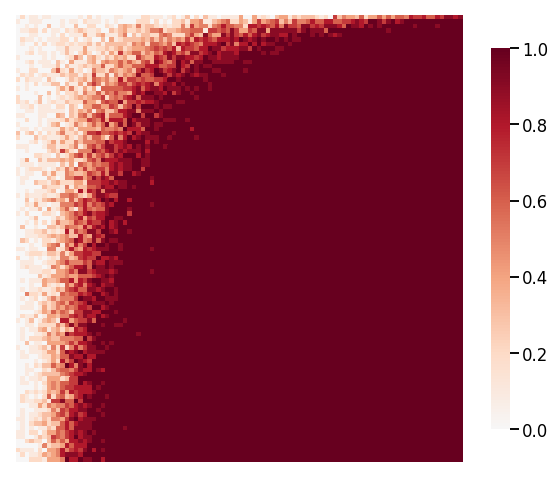

In [19]:
heatmap(arr)